In [1]:
import numpy as np
import matplotlib.pyplot as plt

sample_rate = 1e6
N = 10000 # number of samples to simulate

# Create a tone to act as the transmitter signal
t = np.arange(N)/sample_rate # time vector
f_tone = 0.02e6
tx = np.exp(2j * np.pi * f_tone * t)


In [2]:
d = 0.5 # half wavelength spacing
Nr = 3
theta_degrees = 20 # direction of arrival (feel free to change this, it's arbitrary)
theta = theta_degrees / 180 * np.pi # convert to radians
a = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta)) # Steering Vector
print(a) # note that it's 3 elements long, it's complex, and the first element is 1+0j

[ 1.        +0.j          0.47618256-0.87934645j -0.54650034-0.83745888j]


In [5]:
a = a.reshape(-1,1)
print(a.shape) # 3x1
tx = tx.reshape(-1,1)
print(tx.shape) # 10000x1

# matrix multiply
r = a @ tx.T  # dont get too caught up by the transpose, the important thing is we're multiplying the Steering Vector by the tx signal
print(r.shape) # 3x10000.  r is now going to be a 2D array, 1D is time and 1D is the spatial dimension
n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
r = r + 0.5*n # r and n are both 3x10000


(3, 1)
(10000, 1)
(3, 10000)


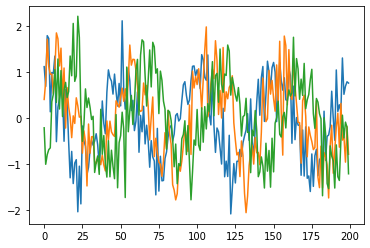

In [6]:
plt.plot(np.asarray(r[0,:]).squeeze().real[0:200]) # the asarray and squeeze are just annoyances we have to do because we came from a matrix
plt.plot(np.asarray(r[1,:]).squeeze().real[0:200])
plt.plot(np.asarray(r[2,:]).squeeze().real[0:200])
plt.show()

In [7]:
num_expected_signals = 3 # Try changing this!

# part that doesn't change with theta_i
R = r @ r.conj().T # Calc covariance matrix, it's Nr x Nr
w, v = np.linalg.eig(R) # eigenvalue decomposition, v[:,i] is the eigenvector corresponding to the eigenvalue w[i]
eig_val_order = np.argsort(np.abs(w)) # find order of magnitude of eigenvalues
v = v[:, eig_val_order] # sort eigenvectors using this order
# We make a new eigenvector matrix representing the "noise subspace", it's just the rest of the eigenvalues
V = np.zeros((Nr, Nr - num_expected_signals), dtype=np.complex64)
for i in range(Nr - num_expected_signals):
   V[:, i] = v[:, i]

theta_scan = np.linspace(-1*np.pi, np.pi, 1000) # -180 to +180 degrees
results = []
for theta_i in theta_scan:
    a = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta_i)) # Steering Vector
    a = a.reshape(-1,1)
    metric = 1 / (a.conj().T @ V @ V.conj().T @ a) # The main MUSIC equation
    metric = np.abs(metric.squeeze()) # take magnitude
    metric = 10*np.log10(metric) # convert to dB
    results.append(metric)

results /= np.max(results) # normalize

/tmp/ipykernel_33930/3359738200.py:18: RuntimeWarning: divide by zero encountered in true_divide
  metric = 1 / (a.conj().T @ V @ V.conj().T @ a) # The main MUSIC equation
/tmp/ipykernel_33930/3359738200.py:18: RuntimeWarning: invalid value encountered in true_divide
  metric = 1 / (a.conj().T @ V @ V.conj().T @ a) # The main MUSIC equation
/tmp/ipykernel_33930/3359738200.py:23: RuntimeWarning: invalid value encountered in true_divide
  results /= np.max(results) # normalize


In [17]:
a = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta_scan[0])) # Steering Vector
a = a.reshape(-1,1)
metric = (a.conj().T @ V @ V.conj().T @ a) # The main MUSIC equation
a.conj().T @ V

array([[1.-0.00000000e+00j, 1.-3.84734139e-16j, 1.-7.69468277e-16j]])